In [28]:
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates import SkyCoord, get_sun,FK4
from astropy.time import Time

from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import astropy.units as u
from scipy.signal import savgol_filter
#paper idea: brightness of the earth in the 1970s vs now

In [29]:
def raeAngFromSource(locations, source):
    position_x = np.array(locations['position_x'], dtype=float)
    position_y = np.array(locations['position_y'], dtype=float)
    position_z = np.array(locations['position_z'], dtype=float)
    
    # Calculate spherical coordinates for all locations
    r = np.sqrt(position_x**2 + position_y**2 + position_z**2)
    latitude = np.degrees(np.arcsin(position_z / r))
    longitude = np.degrees(np.arctan2(position_y, position_x))
    
    ra = (longitude + 180) % 360 * u.deg
    dec = -latitude * u.deg

    
    coord1 = SkyCoord(ra, dec, frame='icrs')
    coord2 = SkyCoord(ra=source[0], dec=source[1], frame='icrs',unit=(u.hourangle, u.deg))

    
    pos_ang = coord1.position_angle(coord2).deg
    ang_sep = angular_separation(coord1.ra, coord1.dec, coord2.ra, coord2.dec)

    
    ang_sep = np.where(pos_ang > 180, -ang_sep, ang_sep)

    return ang_sep.to(u.deg).value

In [30]:
def bandToFreq(band):
    if(band == 1):
        return 0.45
    if(band == 2):
        return 0.70
    if(band == 3):
        return 0.90
    if(band == 4):
        return 1.31
    if(band == 5):
        return 2.20
    if(band == 6):
        return 3.93
    if(band == 7):
        return 4.70
    if(band == 8):
        return 6.55
    if(band == 9):
        return 9.18
    return -1

In [31]:
# Load the file to inspect its contents
filename = r"C:\Users\adamf\Documents\PhD\Diffraction\cleanedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])

In [32]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head(50)

,time,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp
0,1973-07-12 00:00:12.304,1,2545.709503,762.504211,-893.179993,0.117721,0.901642,0.416154,0.860565,-1.015174e+01,4.044755e+06,2.469941e+08,0.000000e+00,0.000000e+00,1092343562
1,1973-07-12 00:00:14.229,1,2544.656067,764.381226,-894.525269,0.117716,0.901642,0.416153,0.863424,-1.018162e+01,4.197954e+06,3.241626e+08,0.000000e+00,0.000000e+00,1092343562
2,1973-07-12 00:00:16.154,1,2543.602631,766.258240,-895.870544,0.117712,0.901643,0.416153,0.866283,-1.021150e+01,4.120635e+06,2.469941e+08,0.000000e+00,0.000000e+00,1092343562
3,1973-07-12 00:00:18.079,1,2542.549194,768.135254,-897.215820,0.117707,0.901644,0.416153,0.869142,-1.024138e+01,4.120635e+06,3.241626e+08,1.475682e+12,3.707425e+08,1092343562
4,1973-07-12 00:00:20.004,1,2541.495758,770.012268,-898.561096,0.117702,0.901644,0.416153,0.872001,-1.027125e+01,4.197954e+06,5.588992e+08,0.000000e+00,0.000000e+00,1092343562
5,1973-07-12 00:00:21.929,1,2540.442322,771.889282,-899.906372,0.117698,0.901645,0.416153,0.874860,-1.030113e+01,4.197954e+06,3.727050e+08,0.000000e+00,0.000000e+00,1092343562
6,1973-07-12 00:00:23.854,1,2539.388885,773.766296,-901.251648,0.117693,0.901646,0.416153,0.877719,-1.033101e+01,4.276719e+06,4.319035e+08,0.000000e+00,0.000000e+00,1092343562
7,1973-07-12 00:00:27.663,9,2537.282013,777.520355,-903.942169,0.117684,0.901647,0.416152,0.883437,-1.039076e+01,2.571561e+05,1.454382e+05,0.000000e+00,0.000000e+00,1092343562
8,1973-07-12 00:00:29.588,9,2536.228577,779.397400,-905.287415,0.117680,0.901648,0.416152,0.886296,-1.042064e+01,2.390345e+05,1.454382e+05,0.000000e+00,0.000000e+00,1092343562
9,1973-07-12 00:00:31.513,9,2535.175140,781.274445,-906.632660,0.117675,0.901648,0.416152,0.889155,-1.045052e+01,2.239194e+05,1.835997e+05,0.000000e+00,0.000000e+00,1092343562


In [33]:
data.set_index('time',inplace=True)

In [34]:
occultTimes = pd.read_csv(r"C:\Users\adamf\Documents\PhD\Diffraction\occultTimeMonth2.csv")

dtSeries= pd.to_datetime(occultTimes['time'])

print(len(dtSeries))



20016


In [35]:
df_orbits = data.iloc[3490000:3600000]#1000000:1100000
print(df_orbits.iloc[0])
print(df_orbits.iloc[-1])

frequency_band         5.000000e+00
position_x            -1.355430e+03
position_y            -1.546042e+03
position_z             1.890914e+03
earth_unit_vector_x    2.695419e-01
earth_unit_vector_y   -8.939703e-01
earth_unit_vector_z   -3.580001e-01
right_ascension        1.456622e+01
declination            4.791290e+01
rv1_coarse             1.316412e+06
rv2_coarse             4.284059e+06
rv1_fine               0.000000e+00
rv2_fine               0.000000e+00
rv_temp                1.092469e+09
Name: 1973-12-11 21:42:36.981000, dtype: float64
frequency_band         4.000000e+00
position_x            -1.675046e+03
position_y             2.191775e+03
position_z            -5.399525e+02
earth_unit_vector_x    9.287057e-01
earth_unit_vector_y   -3.653163e-01
earth_unit_vector_z   -6.363577e-02
right_ascension        7.883883e+00
declination           -1.110201e+01
rv1_coarse             1.646541e+06
rv2_coarse             1.975216e+06
rv1_fine               0.000000e+00
rv2_fine       

In [36]:
windowDuration = 13270.2 #period taken from wikipedia (221.17min*60)
firstPoint = df_orbits.index[0]

timesSince = []


for currentTime in df_orbits.index:
    timeDiff = (currentTime-firstPoint).total_seconds()
    while(timeDiff>windowDuration):
        firstPoint += timedelta(seconds=windowDuration)
        timeDiff = (currentTime-firstPoint).total_seconds()
    timesSince.append(timeDiff)
df_orbits['period_diff'] = timesSince
df_orbits.head(50)

<ipython-input-36-91f7cc6c6ee0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbits['period_diff'] = timesSince


,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,period_diff
time,,,,,,,,,,,,,,,
1973-12-11 21:42:36.981,5,-1355.430115,-1546.041870,1890.913574,0.269542,-0.893970,-0.358000,14.566216,47.912895,1.316412e+06,4.284059e+06,0.000000e+00,0.000000e+00,1092469391,0.000
1973-12-11 21:42:38.906,5,-1353.499603,-1547.703552,1890.945801,0.269548,-0.893969,-0.357999,14.571332,47.920162,1.459311e+06,4.032888e+06,0.000000e+00,0.000000e+00,1092469391,1.925
1973-12-11 21:42:42.716,4,-1349.638702,-1551.026825,1891.010284,0.269559,-0.893967,-0.357997,14.581564,47.934698,1.849434e+06,1.501986e+06,0.000000e+00,0.000000e+00,1092469391,5.735
1973-12-11 21:42:44.641,4,-1347.708313,-1552.688416,1891.042542,0.269564,-0.893965,-0.357996,14.586680,47.941967,2.059230e+06,1.298169e+06,0.000000e+00,0.000000e+00,1092469391,7.660
1973-12-11 21:42:46.566,4,-1345.777924,-1554.350006,1891.074799,0.269570,-0.893964,-0.357995,14.591796,47.949236,2.422329e+06,1.396439e+06,0.000000e+00,0.000000e+00,1092469391,9.585
1973-12-11 21:42:48.491,4,-1343.847534,-1556.011597,1891.107056,0.269576,-0.893963,-0.357993,14.596912,47.956505,2.115672e+06,1.363046e+06,2.059650e+06,1.390531e+06,1092469391,11.510
1973-12-11 21:42:50.416,4,-1341.917145,-1557.673187,1891.139313,0.269581,-0.893962,-0.357992,14.602028,47.963774,1.899793e+06,1.396439e+06,0.000000e+00,0.000000e+00,1092469391,13.435
1973-12-11 21:42:52.341,4,-1339.986755,-1559.334778,1891.171570,0.269587,-0.893960,-0.357991,14.607144,47.971043,2.004655e+06,1.430653e+06,0.000000e+00,0.000000e+00,1092469391,15.360
1973-12-11 21:42:54.266,4,-1338.056366,-1560.996368,1891.203827,0.269593,-0.893959,-0.357990,14.612260,47.978312,2.422329e+06,1.639257e+06,0.000000e+00,0.000000e+00,1092469391,17.285


In [37]:
df_orbits['diffraction'] = df_orbits.index.isin(dtSeries)

<ipython-input-37-555349e9cd00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbits['diffraction'] = df_orbits.index.isin(dtSeries)


In [38]:
occult_df = data[data.index.isin(dtSeries)]
print(len(occult_df))
occult_df = occult_df[~occult_df.index.duplicated(keep='first')]
print(len(occult_df))

16865
16837


In [39]:
occult_df['time_diff'] = occult_df.index.to_series().diff().dt.total_seconds()
occult_df['group'] = (occult_df['time_diff'] > 300).cumsum()

first_times = occult_df.groupby('group').apply(lambda x: x.index.min())
occult_df['first_time_in_group'] = occult_df['group'].map(first_times)

occult_df['window_diff'] = (occult_df.index - occult_df['first_time_in_group']).dt.total_seconds()

# Drop the intermediate columns
occult_df = occult_df.drop(columns=['group','time_diff'])

In [40]:
max_window_diff = occult_df.groupby('first_time_in_group')['window_diff'].max()
print(max_window_diff)
print(np.average(max_window_diff))#average length to go from -2.5 to 2.5 degrees

first_time_in_group
1973-08-01 00:45:27.548    180.493
1973-08-01 01:32:48.874    180.494
1973-08-01 04:27:25.310    178.568
1973-08-01 05:14:44.711    180.494
1973-08-01 08:56:40.548    103.701
                            ...   
1973-08-28 11:11:27.389    180.508
1973-08-29 02:46:37.852    178.582
1973-08-29 06:28:32.839    180.507
1973-08-31 09:28:43.410    149.788
1973-08-31 10:15:34.246    180.507
Name: window_diff, Length: 231, dtype: float64
169.763012987013


In [41]:
df_orbits['window_diff'] = df_orbits.index.map(occult_df['window_diff'])
df_orbits['first_time_in_group'] = df_orbits.index.map(occult_df['first_time_in_group'])
df_orbits.head(140)

<ipython-input-41-0bff9462c069>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbits['window_diff'] = df_orbits.index.map(occult_df['window_diff'])
<ipython-input-41-0bff9462c069>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbits['first_time_in_group'] = df_orbits.index.map(occult_df['first_time_in_group'])


,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,period_diff,diffraction,window_diff,first_time_in_group
time,,,,,,,,,,,,,,,,,,
1973-12-11 21:42:36.981,5,-1355.430115,-1546.041870,1890.913574,0.269542,-0.893970,-0.358000,14.566216,47.912895,1.316412e+06,4.284059e+06,0.0,0.0,1092469391,0.000,False,NaN,NaT
1973-12-11 21:42:38.906,5,-1353.499603,-1547.703552,1890.945801,0.269548,-0.893969,-0.357999,14.571332,47.920162,1.459311e+06,4.032888e+06,0.0,0.0,1092469391,1.925,False,NaN,NaT
1973-12-11 21:42:42.716,4,-1349.638702,-1551.026825,1891.010284,0.269559,-0.893967,-0.357997,14.581564,47.934698,1.849434e+06,1.501986e+06,0.0,0.0,1092469391,5.735,False,NaN,NaT
1973-12-11 21:42:44.641,4,-1347.708313,-1552.688416,1891.042542,0.269564,-0.893965,-0.357996,14.586680,47.941967,2.059230e+06,1.298169e+06,0.0,0.0,1092469391,7.660,False,NaN,NaT
1973-12-11 21:42:46.566,4,-1345.777924,-1554.350006,1891.074799,0.269570,-0.893964,-0.357995,14.591796,47.949236,2.422329e+06,1.396439e+06,0.0,0.0,1092469391,9.585,False,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973-12-11 21:47:59.537,2,-1015.944275,-1805.376709,1873.389221,0.270485,-0.893760,-0.357814,15.438690,48.438915,1.802527e+06,2.786949e+06,0.0,0.0,1092469391,322.556,False,NaN,NaT
1973-12-11 21:48:01.462,2,-1013.851776,-1806.812500,1873.166412,0.270491,-0.893758,-0.357813,15.443914,48.438398,1.871101e+06,2.658696e+06,0.0,0.0,1092469391,324.481,False,NaN,NaT
1973-12-11 21:48:05.271,1,-1009.646057,-1809.647583,1872.682800,0.270502,-0.893756,-0.357811,15.454358,48.436182,7.181626e+05,3.388706e+05,0.0,0.0,1092469391,328.290,False,NaN,NaT


In [42]:
df_orbits.iloc[[0,5354,5376]][['position_x','position_y','position_z','period_diff']]#head(5376)

,position_x,position_y,position_z,period_diff
time,,,,
1973-12-11 21:42:36.981,-1355.430115,-1546.041870,1890.913574,0.000
1973-12-12 01:53:23.832,629.604858,-2384.486206,1313.662292,1776.651
1973-12-12 01:54:13.761,687.131805,-2386.573212,1280.950653,1826.580


In [28]:
sunSource = get_sun(Time(df_orbits.index.to_pydatetime())).transform_to(FK4(equinox=Time('B1950')))

In [34]:
source = ['03h20m47.283s','-37d23m08.10']#FornaxA https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Fornax+A&submit=SIMBAD+search
#source = (['09h34m00s','-14d 59m28'],)#the sun approximately on these days 1973-08-12 -16
#source = ([sunSource.ra[len(sunSource)//2],sunSource.dec[len(sunSource)//2]],)#taking middle point as constant sun position, over 3 days shifted .4 in ra
df_orbits['angularSep'] = raeAngFromSource(df_orbits,source)

<ipython-input-34-90e030660c06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orbits['angularSep'] = raeAngFromSource(df_orbits,source)


In [30]:
df_orbits.head(1450)

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,period_diff,diffraction,window_diff,first_time_in_group,angularSep
time,,,,,,,,,,,,,,,,,,,
1973-12-11 21:42:36.981,5,-1355.430115,-1546.041870,1890.913574,0.269542,-0.893970,-0.358000,14.566216,47.912895,1316412.0,4284059.0,0.0,0.0,1092469391,0.000,False,NaN,NaT,5.333137
1973-12-11 21:42:38.906,5,-1353.499603,-1547.703552,1890.945801,0.269548,-0.893969,-0.357999,14.571332,47.920162,1459311.0,4032888.0,0.0,0.0,1092469391,1.925,False,NaN,NaT,5.322961
1973-12-11 21:42:42.716,4,-1349.638702,-1551.026825,1891.010284,0.269559,-0.893967,-0.357997,14.581564,47.934698,1849434.0,1501986.0,0.0,0.0,1092469391,5.735,False,NaN,NaT,5.304092
1973-12-11 21:42:44.641,4,-1347.708313,-1552.688416,1891.042542,0.269564,-0.893965,-0.357996,14.586680,47.941967,2059230.0,1298169.0,0.0,0.0,1092469391,7.660,False,NaN,NaT,5.295404
1973-12-11 21:42:46.566,4,-1345.777924,-1554.350006,1891.074799,0.269570,-0.893964,-0.357995,14.591796,47.949236,2422329.0,1396439.0,0.0,0.0,1092469391,9.585,False,NaN,NaT,5.287217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973-12-11 22:50:04.268,4,2462.546692,-1184.769531,-619.123779,0.281359,-0.891266,-0.355642,22.202141,-3.890575,2061144.0,1642455.0,0.0,0.0,1092490362,4047.287,False,NaN,NaT,-108.849109
1973-12-11 22:50:06.193,4,2463.026337,-1182.873901,-620.744751,0.281365,-0.891265,-0.355641,22.204731,-3.924772,2340943.0,1542639.0,0.0,0.0,1092490362,4049.212,False,NaN,NaT,-108.900801
1973-12-11 22:50:08.118,4,2463.505981,-1180.978271,-622.365723,0.281370,-0.891264,-0.355640,22.207321,-3.958969,2117760.0,1698386.0,2049860.0,1387309.0,1092490362,4051.137,False,NaN,NaT,-108.952494


In [35]:
%matplotlib qt
mask = df_orbits['diffraction'] == True
print(len(mask))
plt.scatter(df_orbits.index[mask],df_orbits['angularSep'][mask], color='red',label = "Diffraction Candidate")
mask = df_orbits['diffraction'] == False
plt.scatter(df_orbits.index[mask],df_orbits['angularSep'][mask], color='blue')
plt.ylabel("Angular Seperation (degrees)")
plt.xlabel("Time")
plt.legend()

110000


# Earth Occultation

In [43]:
start_date = pd.to_datetime("1973-12-12 04:00")
end_date = pd.to_datetime("1973-12-15 16:00")

# Selecting rows within the date range
earthOccult = df_orbits[(df_orbits.index >= start_date) & (df_orbits.index <= end_date)].copy()

In [44]:
def angularSepEarth(data):
    posList = ['x','y','z']
    earthMoonDist = 384000#km (avg distance)
    earthUnitVector = np.zeros((len(data),len(posList)))
    pos = np.zeros((len(data),len(posList)))
    for i in range(0,len(data)):
        for j in range(0,len(posList)):
            earthUnitVector[i][j] = data.iloc[i]['earth_unit_vector_'+posList[j]]#pointing from center of moon
            pos[i][j] = data.iloc[i]['position_'+posList[j]]
    earthVector = earthUnitVector*earthMoonDist
    raeVector = -earthVector+pos#should be earth centered position of rae
    
    
    dotProd = np.sum(raeVector * pos, axis=1) # Row-wise dot product

    norms = np.linalg.norm(raeVector, axis=1) * np.linalg.norm(pos, axis=1)
    cosTheta = np.clip(dotProd / norms,-1.0,1.0)
    angle = np.arccos(cosTheta)  # Angle in radians
    
    diff = np.diff(np.sum(raeVector*raeVector,axis=1))
    sign = np.sign(diff)
    sign = np.append(sign,sign[-1])
    #normRaeVec = raeVector / np.linalg.norm(raeVector, axis=1, keepdims=True)
    #normPosVec = pos / np.linalg.norm(pos, axis=1, keepdims=True)
    #sign = np.sign(normPosVec[:,0])
    #planeNormal = np.cross(earthUnitVector,np.array([1,0,0]))
    #signs = np.sign(np.sum(planeNormal*pos,axis=1))
    
    return sign*angle*180/np.pi  # Convert to degrees

In [45]:
earthOccult['earth_angle']= angularSepEarth(earthOccult)

In [46]:
earthOccult.head()

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,period_diff,diffraction,window_diff,first_time_in_group,earth_angle
time,,,,,,,,,,,,,,,,,,,
1973-12-12 04:00:03.073,2,-1609.390228,2218.826569,-613.873047,0.334998,-0.877124,-0.344135,7.785106,-12.531792,2868692.0,2603014.0,0.0,0.0,1092343562,9375.892,False,NaN,NaT,35.700203
1973-12-12 04:00:04.998,2,-1611.125671,2217.972717,-612.236084,0.335004,-0.877123,-0.344134,7.787829,-12.499399,2868692.0,2891073.0,0.0,0.0,1092343562,9377.817,False,NaN,NaT,35.685296
1973-12-12 04:00:06.923,2,-1612.861115,2217.118866,-610.599121,0.335009,-0.877121,-0.344133,7.790551,-12.467006,2620994.0,2728489.0,0.0,0.0,1092343562,9379.742,False,NaN,NaT,35.670447
1973-12-12 04:00:08.848,2,-1614.596558,2216.265015,-608.962158,0.335015,-0.877119,-0.344132,7.793274,-12.434614,3156127.0,2482369.0,2665320.0,2592544.0,1092343562,9381.667,False,NaN,NaT,35.655655
1973-12-12 04:00:10.773,2,-1616.332001,2215.411163,-607.325195,0.335020,-0.877118,-0.344130,7.795996,-12.402221,2868692.0,2603014.0,0.0,0.0,1092343562,9383.592,False,NaN,NaT,35.640921


Text(0, 0.5, 'angle')

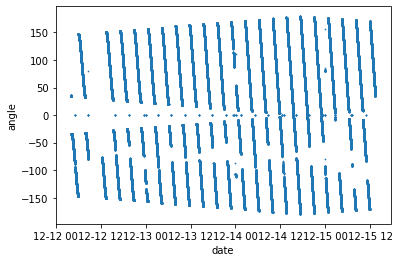

In [47]:
%matplotlib inline
plt.scatter(earthOccult.index,earthOccult['earth_angle'],s=0.5)
plt.xlabel("date")
plt.ylabel("angle")

In [48]:
earthFreq = earthOccult['frequency_band'].unique()

In [49]:
earthOccult['TimeSince'] = (earthOccult.index-earthOccult.index[0]).total_seconds()

In [50]:
start_date = pd.to_datetime("1973-12-14 04:00")
end_date = pd.to_datetime("1973-12-14 16:00")

# Selecting rows within the date range
earthOccultClip = earthOccult[(earthOccult.index >= start_date) & (earthOccult.index <= end_date)].copy()

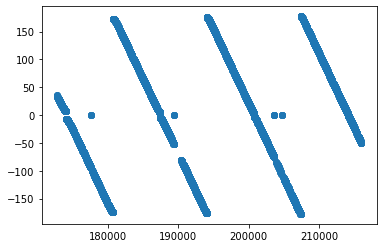

In [51]:
%matplotlib inline
plt.scatter(earthOccultClip['TimeSince'],earthOccultClip['earth_angle'])

In [52]:
# Define the threshold for earth_angle
threshold = 150  # Example threshold for crossing

# Initialize the orbit number and a list to store the orbit numbers
orbit_num = 0
orbit_numbers = []

# Iterate through the rows in earthOccultClip
previous_angle = earthOccultClip['earth_angle'].iloc[0]

for i, current_angle in enumerate(earthOccultClip['earth_angle']):
    if current_angle > threshold and previous_angle <= threshold:
        # Increment orbit number when crossing the threshold
        orbit_num += 1
    
    # Append the current orbit number to the list
    orbit_numbers.append(orbit_num)
    
    # Update previous_angle for the next iteration
    previous_angle = current_angle

# Add the orbit_num column to earthOccultClip
earthOccultClip['orbit_num'] = orbit_numbers

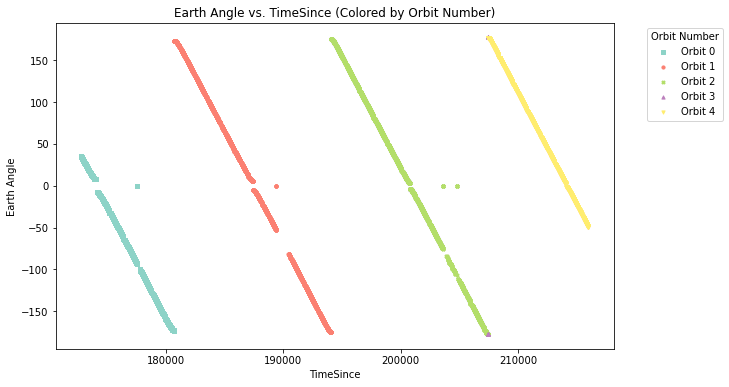

In [53]:
%matplotlib inline
unique_orbits = earthOccultClip['orbit_num'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_orbits)))
markers = ['s', 'o', 'X', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 's', 'x', 'd']

# Create a color map dictionary for orbit numbers
orbit_color_map = {orbit: color for orbit, color in zip(unique_orbits, colors)}
orbit_marker_map = {orbit: markers[i % len(markers)] for i, orbit in enumerate(earthOccultClip['orbit_num'].unique())}

plt.figure(figsize=(10, 6))

# Plot each point with the corresponding color based on orbit_num
for orbit in unique_orbits:
    subset = earthOccultClip[earthOccultClip['orbit_num'] == orbit]
    plt.scatter(subset['TimeSince'], subset['earth_angle'], 
                color=orbit_color_map[orbit], marker=orbit_marker_map[orbit],label=f'Orbit {orbit}', s=10)

# Add labels and title
plt.xlabel('TimeSince')
plt.ylabel('Earth Angle')
plt.title('Earth Angle vs. TimeSince (Colored by Orbit Number)')
plt.legend(title='Orbit Number', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [54]:
%matplotlib qt

fig, axes = plt.subplots(3, 3, figsize=(10, 5 * len(earthFreq)), sharex=True)
markers = ['s', 'o', 'X', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 's', 'x', 'd']


for ax, freq in zip(axes.flatten(), earthFreq):
    freq_df = earthOccultClip[earthOccultClip['frequency_band'] == freq]
    unique_orbits = freq_df['orbit_num'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_orbits)))

    # Create a color map dictionary for orbit numbers
    orbit_color_map = {orbit: color for orbit, color in zip(unique_orbits, colors)}
    orbit_marker_map = {orbit: markers[i % len(markers)] for i, orbit in enumerate(freq_df['orbit_num'].unique())}
    
    for orbit in unique_orbits:
        subset = freq_df[freq_df['orbit_num'] == orbit]
        ax.scatter(subset['earth_angle'],subset['rv1_coarse'], linestyle='-', s=4, color=orbit_color_map[orbit],
                  marker = orbit_marker_map[orbit])
        

    
    #ax.scatter(freq_df['earth_angle'], freq_df['rv1_coarse'], marker='o', linestyle='-',s=4)
    #ax.scatter(freq_df['TimeSince'], freq_df['rv1_coarse'], marker='o', linestyle='-',s=2)
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    #ax.axvline(pd.Timestamp('1973-12-12 15:00:00'), color='blue', linestyle='--', label='15:00')
    #ax.axvline(pd.Timestamp('1973-12-12 15:30:00'), color='blue', linestyle='--', label='15:30')
    ax.set_xlabel('Time')
    #ax.set_yscale('log')
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)
    #zero_window_diff_rows = freq_df[freq_df['window_diff'] == 0.0]
    #for _, row in zero_window_diff_rows.iterrows():
        #ax.axvline(x=row['angularSepFornaxA'], color='r', linestyle='--', linewidth=1)
plt.tight_layout()

In [33]:
%matplotlib qt
markers = ['s', 'o', 'X', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 's', 'x', 'd']
freq_band = 6

freq_df = earthOccultClip[earthOccultClip['frequency_band'] == freq_band]
unique_orbits = freq_df['orbit_num'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_orbits)))

# Create a color map dictionary for orbit numbers
orbit_color_map = {orbit: color for orbit, color in zip(unique_orbits, colors)}
orbit_marker_map = {orbit: markers[i % len(markers)] for i, orbit in enumerate(freq_df['orbit_num'].unique())}
    
for orbit in unique_orbits:
    subset = freq_df[freq_df['orbit_num'] == orbit]
    plt.scatter(subset['earth_angle'],subset['rv1_coarse'], linestyle='-', s=20, color=orbit_color_map[orbit],
              marker = orbit_marker_map[orbit])
plt.title(f'Frequency: {bandToFreq(freq_band)}MHz')
plt.xlabel('Angle')
plt.ylabel('rv1_coarse')
plt.grid(True)

In [26]:
freq_df = earthOccult[earthOccult['frequency_band'] == 8]
plt.scatter(freq_df.index, freq_df['rv1_coarse'], marker='o', linestyle='-')
plt.title(f'Frequency: {bandToFreq(8)}MHz')
#plt.axvline(pd.Timestamp('1973-12-12 15:00:00'), color='blue', linestyle='--', label='15:00')
#plt.axvline(pd.Timestamp('1973-12-12 15:30:00'), color='blue', linestyle='--', label='15:30')
plt.xlabel('Time')
plt.ylabel('Upper V')


Text(0, 0.5, 'Upper V')

BACK TO NORMAL

In [43]:
filtered_dfOccult = df_orbits[(df_orbits['angularSep'] >= -10) & (df_orbits['angularSep'] <= 10)]
medianValuesOcculted = filtered_dfOccult.groupby('frequency_band')[['rv1_coarse','rv2_coarse']].median().reset_index()

In [44]:
print("Occulted")
#print(average_values)
print(medianValuesOcculted)

Occulted
   frequency_band    rv1_coarse    rv2_coarse
0               1  2.252280e+06  1.193737e+06
1               2  2.817067e+06  2.465394e+06
2               3  2.007695e+06  1.496083e+06
3               4  1.967262e+06  1.250557e+06
4               5  3.700755e+06  4.100458e+06
5               6  7.368984e+05  4.195458e+05
6               7  4.781627e+05  3.869278e+05
7               8  3.130286e+05  6.509732e+05
8               9  2.006996e+05  3.051670e+05


In [45]:
filtered_df_noOccult = df_orbits[((df_orbits['angularSepFornaxA'] >= 30)&(df_orbits['angularSepFornaxA'] <= 50)) 
                        | (df_orbits['angularSepFornaxA'] <= -30)&(df_orbits['angularSepFornaxA'] >= -50)]
medianValues_noOccult = filtered_df_noOccult.groupby('frequency_band')[['rv1_coarse','rv2_coarse']].median().reset_index()

In [46]:
print("Visible")
#print(average_valuesTest)
print(medianValues_noOccult)

Visible
   frequency_band    rv1_coarse   rv2_coarse
0               1  4.227289e+06  1910649.000
1               2  2.860944e+06  2874262.000
2               3  2.059497e+06  1957797.000
3               4  1.923975e+06  1523360.000
4               5  3.511977e+06  4761357.000
5               6  7.452968e+05   440117.375
6               7  4.773590e+05   395365.375
7               8  3.035286e+05   636907.000
8               9  2.271779e+05   301246.875


Text(0, 0.5, 'RV1_Coarse')

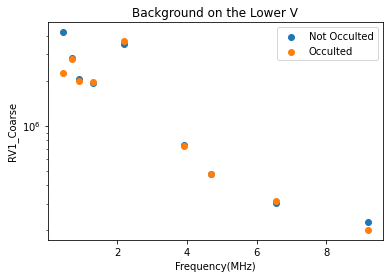

In [47]:
%matplotlib inline
vec_bandToFreq = np.vectorize(bandToFreq)
plt.scatter(vec_bandToFreq(medianValues_noOccult['frequency_band']),medianValues_noOccult['rv1_coarse'])
plt.scatter(vec_bandToFreq(medianValuesOcculted['frequency_band']),medianValuesOcculted['rv1_coarse'])
plt.legend(['Not Occulted','Occulted'])
plt.yscale('log')
plt.title('Background on the Lower V')
plt.xlabel('Frequency(MHz)')
plt.ylabel('RV1_Coarse')

In [60]:
frequencies = df_orbits['frequency_band'].unique()


In [49]:
unique_first_times = df_orbits['first_time_in_group'].unique()
unique_first_times = pd.to_datetime(unique_first_times)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_first_times)))
color_map = dict(zip(unique_first_times, colors))


In [119]:
df_chopped = df_orbits.iloc[0:4725]#0 to 4725 for 1 orbit

In [120]:
df_chopped['earth_angle']= angularSepEarth(df_chopped)

<ipython-input-120-b5e04014f326>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chopped['earth_angle']= angularSepEarth(df_chopped)


In [121]:
print(df_chopped.iloc[0])
print(df_chopped.iloc[-1])

frequency_band                   5
position_x            -1355.430115
position_y             -1546.04187
position_z             1890.913574
earth_unit_vector_x       0.269542
earth_unit_vector_y       -0.89397
earth_unit_vector_z         -0.358
right_ascension          14.566216
declination              47.912895
rv1_coarse               1316412.0
rv2_coarse               4284059.0
rv1_fine                       0.0
rv2_fine                       0.0
rv_temp                 1092469391
period_diff                    0.0
diffraction                  False
window_diff                    NaN
first_time_in_group            NaT
angularSep              100.281308
earth_angle             -96.573446
Name: 1973-12-11 21:42:36.981000, dtype: object
frequency_band                   2
position_x            -2270.747162
position_y             -349.862549
position_z             1596.776215
earth_unit_vector_x       0.304849
earth_unit_vector_y      -0.885454
earth_unit_vector_z      -0.350767
right_a

In [126]:
%matplotlib qt
#TODO add colours to points in the same orbit
fig, axes = plt.subplots(3, 3, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes.flatten(), frequencies):
    freq_df = df_chopped[df_chopped['frequency_band'] == freq]
    
    
    #ax.scatter(freq_df['angularSep'], freq_df['rv1_coarse'], marker='o', linestyle='-',s=4)
    ax.scatter(freq_df['period_diff'], freq_df['rv1_coarse'], marker='o', linestyle='-',s=4)
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    #ax.set_xlabel('Angle between center of moon and sun')
    
    ax.set_xlabel('Time Difference (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)

In [50]:
%matplotlib qt
#TODO add colours to points in the same orbit
fig, axes = plt.subplots(len(frequencies), 1, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes, frequencies):
    freq_df = df_orbits[df_orbits['frequency_band'] == freq]
    
    
    ax.scatter(freq_df['angularSep'], freq_df['rv1_coarse'], marker='o', linestyle='-')
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    ax.set_xlabel('Time since start of period (s)')
    
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)
    #zero_window_diff_rows = freq_df[freq_df['window_diff'] == 0.0]
    #for _, row in zero_window_diff_rows.iterrows():
        #ax.axvline(x=row['angularSepFornaxA'], color='r', linestyle='--', linewidth=1)
    diffraction_true_rows = freq_df[freq_df['diffraction'] == True]
    for _, row in diffraction_true_rows.iterrows():
        first_time = row['first_time_in_group']
        color = color_map[first_time]
        ax.axvspan(row['angularSepFornaxA'] - 2, row['angularSepFornaxA'] + 2, color=color, alpha=0.01)
    #avgFreq = average_values.loc[average_values['frequency_band'] == freq, 'avg_rv1_coarse'].values[0]
    #ax.axhline(y=avgFreq,linewidth=2)
    #ax.grid(True)
    #ax.set_yscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
first_index = df_orbits.index[0]
last_index = df_orbits.index[-1]
fig.text(0, 0, f'First Index: {first_index}, Last Index: {last_index}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

Text(0, 0, 'First Index: 1973-08-05 07:19:28.981000, Last Index: 1973-08-09 03:53:41.059000')

In [ ]:
def calculate_binned_median(df):
    group_df = df.copy()
    bins_edge = np.linspace(-180, 180, 91)
    bin_indices = np.digitize(group_df['angularSepFornaxA'], bins_edge)
    group_df['bin'] = bin_indices
    
    # Group by both 'frequency_band' and 'bin' and calculate the median
    binned_median = group_df.groupby(['frequency_band', 'bin'])['rv1_coarse'].median().reset_index()
    binned_median = binned_median.rename(columns={'rv1_coarse': 'median_rv1_coarse'})
    
    # Merge the median values back to the original dataframe
    group_df = group_df.merge(binned_median, on=['frequency_band', 'bin'], how='left')
    return group_df['median_rv1_coarse'].values

In [ ]:
def calculate_binned_medianTime(df):
    group_df = df.copy()
    group_df['burst_group'] = (group_df['frequency_band'] != group_df['frequency_band'].shift()).cumsum()
    group_df['median_rv1_coarse'] = group_df.groupby(['frequency_band', 'burst_group'])['rv1_coarse'].transform('median')
    group_df.head(30)
    return group_df['median_rv1_coarse'].values

In [ ]:
try:
    df_orbitsClipped.drop(['median_rv1_coarse','median_rv1_coarse_time'],axis=1,inplace=True)
except:
    pass

In [ ]:
# Calculate binned median for each frequency band
temp = calculate_binned_median(df_orbitsClipped)

tempTime = calculate_binned_medianTime(df_orbitsClipped)

df_orbitsClipped['median_rv1_coarse']=temp
df_orbitsClipped['median_rv1_coarse_time'] = tempTime

In [ ]:
%matplotlib qt
fig, axes = plt.subplots(len(frequencies), 1, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes, frequencies):
    freq_df = df_orbitsClipped[df_orbitsClipped['frequency_band'] == freq]
    medianFreq = medianValuesOcculted.loc[medianValuesOcculted['frequency_band'] == freq, 'rv1_coarse'].values[0]
    
    ax.scatter(freq_df['period_diff'], freq_df['median_rv1_coarse_time']-medianFreq, marker='o', linestyle='-')
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    ax.set_xlabel('Time since start of period (s)')
    
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)
    #zero_window_diff_rows = freq_df[freq_df['window_diff'] == 0.0]
    #for _, row in zero_window_diff_rows.iterrows():
        #ax.axvline(x=row['angularSepFornaxA'], color='r', linestyle='--', linewidth=1)
    diffraction_true_rows = freq_df[freq_df['diffraction'] == True]
    for _, row in diffraction_true_rows.iterrows():
        first_time = row['first_time_in_group']
        color = color_map[first_time]
        ax.axvspan(row['period_diff'] - 2, row['period_diff'] + 2, color=color, alpha=0.1)
    #avgFreq = average_values.loc[average_values['frequency_band'] == freq, 'avg_rv1_coarse'].values[0]
    #ax.axhline(y=avgFreq,linewidth=2)
    #ax.grid(True)
    #ax.set_yscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
first_index = df_orbitsClipped.index[0]
last_index = df_orbitsClipped.index[-1]
fig.text(0, 0, f'First Index: {first_index}, Last Index: {last_index}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

# applying savgol filter

In [48]:
def apply_savgol_filter(group_df, window_length=201, polyorder=4):
    group_df['rv1_coarse_smooth'] = savgol_filter(group_df['rv1_coarse'], window_length, polyorder)
    return group_df

In [50]:
df_orbits = df_orbits.groupby('frequency_band').apply(apply_savgol_filter)

In [51]:
df_orbits.head(15)

,frequency_band,position_x,position_y,position_z,earth_unit_vector_x,earth_unit_vector_y,earth_unit_vector_z,right_ascension,declination,rv1_coarse,rv2_coarse,rv1_fine,rv2_fine,rv_temp,period_diff,diffraction,window_diff,first_time_in_group,angularSepFornaxA,rv1_coarse_smooth
time,,,,,,,,,,,,,,,,,,,,
1973-08-04 22:20:06.427,6,1642.146729,-1928.116364,1194.914520,0.855003,0.436589,0.279927,20.354204,33.285200,7.289344e+05,7.280931e+05,0.0,0.000,1092154818,0.000,False,NaN,NaT,-67.597968,7.844515e+05
1973-08-04 22:20:08.352,6,1644.153809,-1927.088745,1193.743774,0.855001,0.436593,0.279928,20.357826,33.260567,7.289344e+05,8.470211e+05,1113425.0,663849.875,1092154818,1.925,False,NaN,NaT,-67.649920,7.802509e+05
1973-08-04 22:20:10.277,6,1646.160889,-1926.061127,1192.573029,0.854998,0.436597,0.279930,20.361448,33.235933,6.634138e+05,6.922850e+05,0.0,0.000,1092154818,3.850,False,NaN,NaT,-67.701873,7.763162e+05
1973-08-04 22:20:12.202,6,1648.167969,-1925.033508,1191.402283,0.854996,0.436601,0.279931,20.365070,33.211300,8.026626e+05,5.379882e+05,0.0,0.000,1092154818,5.775,False,NaN,NaT,-67.753827,7.726402e+05
1973-08-04 22:20:14.127,6,1650.175049,-1924.005890,1190.231537,0.854993,0.436605,0.279933,20.368692,33.186666,7.289344e+05,5.658128e+05,0.0,0.000,1092154818,7.700,False,NaN,NaT,-67.805782,7.692161e+05
1973-08-04 22:20:17.936,5,1654.189758,-1921.950409,1187.889709,0.854988,0.436613,0.279936,20.375935,33.137392,3.821686e+06,5.803312e+06,0.0,0.000,1092154818,11.509,False,NaN,NaT,-67.909708,3.520689e+06
1973-08-04 22:20:19.861,5,1656.197388,-1920.922546,1186.718628,0.854986,0.436616,0.279937,20.379555,33.112751,3.658006e+06,5.321088e+06,0.0,0.000,1092154818,13.434,False,NaN,NaT,-67.961679,3.574578e+06
1973-08-04 22:20:21.786,5,1658.205017,-1919.894684,1185.547546,0.854983,0.436620,0.279939,20.383175,33.088110,4.205391e+06,4.578581e+06,0.0,0.000,1092154818,15.359,False,NaN,NaT,-68.013650,3.625655e+06
1973-08-04 22:20:23.711,5,1660.212646,-1918.866821,1184.376465,0.854981,0.436624,0.279940,20.386795,33.063469,3.821686e+06,5.321088e+06,3708775.0,4738599.000,1092154818,17.284,False,NaN,NaT,-68.065622,3.673982e+06


In [52]:
%matplotlib qt
fig, axes = plt.subplots(len(frequencies), 1, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes, frequencies):
    freq_df = df_orbits[df_orbits['frequency_band'] == freq]
    
    
    ax.scatter(freq_df['angularSepFornaxA'], freq_df['rv1_coarse_smooth'], marker='o', linestyle='-')
    ax.set_title(f'Frequency: {bandToFreq(freq)}MHz')
    ax.set_xlabel('Angular Seperation (Deg)')
    
    #ax.set_xlabel('Time Difference modulo orbital period (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)
    #zero_window_diff_rows = freq_df[freq_df['window_diff'] == 0.0]
    #for _, row in zero_window_diff_rows.iterrows():
        #ax.axvline(x=row['angularSepFornaxA'], color='r', linestyle='--', linewidth=1)
    diffraction_true_rows = freq_df[freq_df['diffraction'] == True]
    for _, row in diffraction_true_rows.iterrows():
        first_time = row['first_time_in_group']
        color = color_map[first_time]
        ax.axvspan(row['angularSepFornaxA'] - 2, row['angularSepFornaxA'] + 2, color=color, alpha=0.01)
    #avgFreq = average_values.loc[average_values['frequency_band'] == freq, 'avg_rv1_coarse'].values[0]
    #ax.axhline(y=avgFreq,linewidth=2)
    #ax.grid(True)
    #ax.set_yscale('log')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
first_index = df_orbitsClipped.index[0]
last_index = df_orbitsClipped.index[-1]
fig.text(0, 0, f'First Index: {first_index}, Last Index: {last_index}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

NameError: name 'df_orbitsClipped' is not defined

In [ ]:
%matplotlib inline 
diffs = np.diff(occult_df['first_time_in_group'])
diffs = diffs[diffs != np.timedelta64(0, 's')]
seconds = np.array([diff / np.timedelta64(1, 's') for diff in diffs])
#print(np.min(seconds))
#print(seconds)
# Create a histogram
plt.hist(seconds[seconds<14400], bins=20, edgecolor='black')#14400 seconds is 4 hours
plt.title("Time Between Sucessive Occultation Regions")
plt.xlabel("Time (s)")
plt.ylabel("Frequency")

In [ ]:
plt.hist(occult_df['window_diff'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.title('Time difference from start of group')
plt.show()

In [ ]:
filtered_df = occult_df[occult_df['window_diff'] <= 600]

In [ ]:
frequencies = filtered_df['frequency_band'].unique()

In [ ]:
%matplotlib qt
fig, axes = plt.subplots(len(frequencies), 1, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes, frequencies):
    freq_df = filtered_df[filtered_df['frequency_band'] == freq]
    ax.scatter(freq_df['window_diff'], freq_df['rv1_coarse'], marker='o', linestyle='-')
    ax.set_title(f'Frequency: {freq}')
    ax.set_xlabel('Time Difference since start of diffraction (seconds)')
    ax.set_ylabel('rv1_coarse')
    avgFreq = average_values.loc[average_values['frequency_band'] == freq, 'avg_rv1_coarse'].values[0]
    #ax.axhline(y=avgFreq,linewidth=2)
    ax.grid(True)
    
plt.tight_layout()

In [ ]:
%matplotlib qt
fig, axes = plt.subplots(len(frequencies), 1, figsize=(10, 5 * len(frequencies)), sharex=True)
for ax, freq in zip(axes, frequencies):
    freq_df = filtered_df[filtered_df['frequency_band'] == freq]
    ax.scatter(freq_df['window_diff'], freq_df['rv1_coarse'], marker='o', linestyle='-')
    ax.set_title(f'Frequency: {freq}')
    ax.set_xlabel('Time Difference since start of diffraction (seconds)')
    ax.set_ylabel('rv1_coarse')
    ax.grid(True)#TODO BACKGROUND SUBTRACTION